# importing  modules

In [1]:
import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Loading The Dataset

In [2]:
def loadSalinasData():
    data_path = os.path.join('F:\main_project\Datasets')
    data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    
    return data, labels

In [3]:
data_set, gt=loadSalinasData()

# Splitting the dataset

In [4]:
train_fraction = 0.85
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 46000.
Number of test samples = 8127.


A portion of training data can optionally be set aside for validation.

In [5]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt , val_fraction=val_fraction)

In [6]:
data_set= util.reduce_dim(img_data=data_set, n_components=150)
data_set.shape

(512, 217, 150)

# Creating inputs for MLP

In [7]:
patch_size=1
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols) 
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels) 

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

# Creating an MLP neural network

In [8]:
units_1 = 2**8
drop_rate =0.35
num_catg = len(catg_labels)
input_shape = (patch_size, patch_size, data_set.shape[-1])

# Building a MLP network model
nn_model = models.Sequential()
#
# dense_input
nn_model.add(layer=layers.Dense(units=data_set.shape[2], activation='relu',
                                input_shape=input_shape))
# flatten_1, changes input shape from (1,1,num_band) to (num_band,)
nn_model.add(layer=layers.Flatten())
# dense_1
nn_model.add(layer=layers.Dense(units=units_1, activation='relu')) 
# dropout_1
nn_model.add(layer=layers.Dropout(drop_rate))
# dense_output
nn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 1, 150)         22650     
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               38656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4112      
Total params: 65,418
Trainable params: 65,418
Non-trainable params: 0
_________________________________________________________________


# Training model

In [9]:
lr = 1e-4
batch_size = 2**3

# Compiling the modele
nn_model.compile(optimizer=optimizers.RMSprop(lr=lr),
                 loss=losses.categorical_crossentropy,
                 metrics=[metrics.categorical_accuracy])

# Training the model
nn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                       epochs=15, validation_data=(val_input, y_val), verbose=False)

# Model performance evaluation

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import spectral
import matplotlib

In [11]:
def reports (X_test,y_test):
    Y_pred =nn_model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow'
               ,'Fallow_smooth', 'Stubble', 'Celery', 
                'Grapes_untrained', 'Soil_vinyard_develop', 'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk',
               'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained',
               'Vinyard_vertical_trellis']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    avgAcc=[]
    classArray=[]
    for c in range(len(confusion)):
        recallSoc=confusion[c][c]/sum(confusion[c])
        classArray+=[recallSoc]
    avgAcc.append(sum(classArray)/len(classArray))
    avg_accuracy=np.mean(avgAcc)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    overall_loss, overall_accu = nn_model.evaluate(X_test, y_test, verbose=False)
    
    
    return classification, confusion, kappa,  overall_accu, avg_accuracy


In [12]:
classification, confusion,  kappa, overall_accuracy, avg_accuracy = reports(test_input,y_test)
print('Classification_report:\n')
print('{}\n'.format(classification))
print('Confusion_matrix :\n')
print('{}\n'.format(confusion))
print('Kappa value : {}\n'.format(kappa))
print('Overall accuracy : {}\n'.format(overall_accuracy))
print('Average_accuracy : {}\n'.format(avg_accuracy))

Classification_report:

                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       0.99      1.00      0.99       302
    Brocoli_green_weeds_2       1.00      0.99      1.00       559
                   Fallow       1.00      1.00      1.00       297
        Fallow_rough_plow       0.98      1.00      0.99       210
            Fallow_smooth       0.99      0.99      0.99       402
                  Stubble       1.00      1.00      1.00       594
                   Celery       1.00      1.00      1.00       537
         Grapes_untrained       0.84      0.90      0.87      1691
     Soil_vinyard_develop       0.99      1.00      1.00       931
Corn_senesced_green_weeds       0.98      0.98      0.98       492
      Lettuce_romaine_4wk       0.99      0.99      0.99       161
      Lettuce_romaine_5wk       1.00      1.00      1.00       289
      Lettuce_romaine_6wk       1.00      1.00      1.00       138
      Lettuce_romaine_7wk       0.97 

Text(0.5, 1.0, 'Classification Map of GroundTruth')

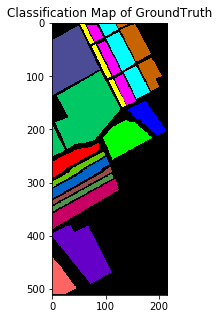

In [13]:
ground_truth = spectral.imshow(classes = gt,figsize =(5,5))
plt.title('Classification Map of GroundTruth')

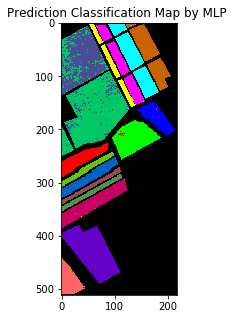

In [14]:
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)

partial_map = util.plot_partial_map(nn_model, gt, pixel_indices, concat_input,
                            concat_y, int_to_vector_dict, plo=False)
full_map = util.plot_full_map(nn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)
predicted_image=spectral.imshow(classes=partial_map.astype(int),figsize =(5,5),cmap= 'jet')
plt.title('Prediction Classification Map by MLP ')
plt.show()

In [15]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [16]:
df = extract_pixels(data_set, gt)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:18<00:00,  7.93it/s]


In [17]:
df.to_csv('data_set.csv', index=False)

In [18]:
df = pd.read_csv('data_set.csv')

In [19]:
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-142,band-143,band-144,band-145,band-146,band-147,band-148,band-149,band-150,class
0,-6136.415770,-4385.651601,628.426690,-302.089387,-7.164320,48.222012,-129.801973,-28.045863,31.953506,69.756525,...,3.037389,-1.381701,2.620902,-4.800118,1.417395,-0.960677,1.397087,1.726514,-5.739930,0
1,-6196.986718,-4360.590266,568.289463,-269.925094,-1.914969,-13.422142,-141.516132,-48.425747,56.946711,62.859663,...,-0.913685,-2.823307,-0.019996,0.748702,1.886806,4.492064,-0.307440,-3.016433,-2.553250,0
2,-6359.538817,-4693.892811,578.047775,-286.413937,18.366365,-17.493501,-122.449201,-23.107800,27.357095,64.968585,...,-1.615104,4.355734,-1.610350,2.325940,3.117173,0.889400,0.473037,3.622306,0.518859,0
3,-6583.700658,-5103.974489,630.466845,-313.787607,39.673922,-9.386642,-130.574810,-14.943107,24.519472,63.060403,...,-2.040040,-2.437065,5.148371,-2.977446,-1.729317,-3.450734,-1.618881,-0.312905,1.183328,0
4,-6834.644650,-5385.604040,666.876042,-327.332038,24.787586,-19.604360,-134.531359,-30.850479,28.726584,83.725078,...,-3.318838,-5.302772,-1.661761,4.291271,-1.117978,3.289693,0.537928,-7.719739,-2.486310,0


In [20]:
df.tail()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-142,band-143,band-144,band-145,band-146,band-147,band-148,band-149,band-150,class
111099,-6775.474571,-4038.470245,552.142554,148.512141,151.186060,32.580887,-31.099437,-56.804632,40.263375,26.496936,...,-6.369894,-2.005346,2.853168,2.891696,-2.991629,-5.878783,-1.235394,-2.880598,-1.509667,0
111100,-6774.761022,-4165.921895,584.737877,133.706533,152.864543,39.471971,-24.964615,-36.861132,9.892694,13.524440,...,-3.579263,-7.296161,0.650028,-0.453338,3.043978,-1.266823,0.285646,-0.305005,-1.653970,0
111101,-6740.517719,-4127.147906,595.008085,114.590064,139.535660,7.656798,17.276998,26.566707,1.154693,27.425222,...,1.886787,0.922374,0.413855,0.361434,2.127095,-6.059590,2.795853,0.060397,0.920305,0
111102,-6763.546218,-4135.167926,579.176378,128.329374,145.436590,35.552630,-17.014588,-6.591298,-18.197554,15.380379,...,-1.689979,-0.173244,-4.410649,1.589902,2.406484,6.970134,1.969298,3.518003,0.221799,0
111103,-6664.104928,-4017.885355,583.409140,147.467756,144.049311,41.358015,20.818885,27.316298,-27.796914,3.627901,...,3.504810,-1.842117,4.621379,0.089260,1.033917,-0.569737,0.497069,-0.297261,-7.909082,0


In [21]:
df.count()

band-1      111104
band-2      111104
band-3      111104
band-4      111104
band-5      111104
             ...  
band-147    111104
band-148    111104
band-149    111104
band-150    111104
class       111104
Length: 151, dtype: int64

In [22]:
Dataset = df.iloc[:, :-1].values

groundTruth = df.iloc[:, -1].values

In [23]:
Dataset.shape, groundTruth.shape

((111104, 150), (111104,))

In [24]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 151), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

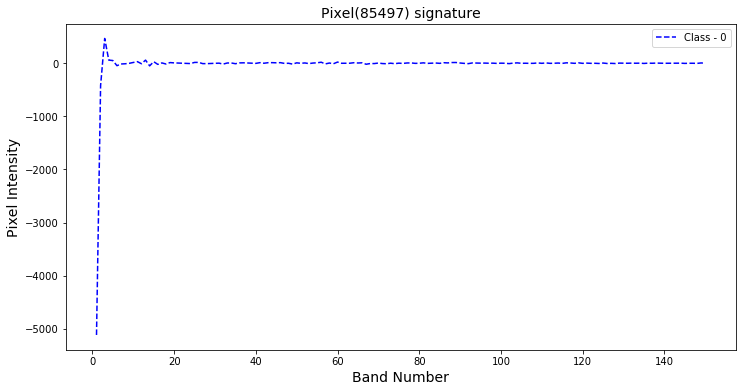

In [25]:
plot_signature(df)

In [26]:
print(f"Unique Class Labels: {df.loc[:, 'class'].unique()}")

Unique Class Labels: [ 0  6  7  4  5 15  8  3  2  1 11 12 13 14 10  9 16]


In [27]:
df.loc[:, 'class'].value_counts()

0     56975
8     11271
15     7268
9      6203
6      3959
2      3726
7      3579
10     3278
5      2678
1      2009
3      1976
12     1927
16     1807
4      1394
14     1070
11     1068
13      916
Name: class, dtype: int64

In [28]:
df[df['class']== 13][0:3000]

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-142,band-143,band-144,band-145,band-146,band-147,band-148,band-149,band-150,class
58916,-591.641603,-842.181547,-53.097883,385.593162,-361.048273,318.674358,-73.294016,137.632578,0.447494,-14.390279,...,0.845702,-2.628200,-0.692171,2.063063,-1.990714,-0.918951,3.331085,-4.573814,0.236368,13
59131,157.535200,-682.783697,-134.252053,435.624033,-449.957251,348.890332,-73.683214,103.837367,98.787238,-5.947146,...,3.575918,1.121842,1.681807,-1.826023,-2.867460,-3.074030,-8.110666,0.298888,-4.087072,13
59132,-356.532225,-834.337565,-70.292462,424.137589,-392.806675,334.046208,-94.337996,106.327566,80.965446,-14.046088,...,-1.703525,-3.904517,-3.935678,2.828602,2.767305,-0.379767,-3.069890,-0.450920,-0.812247,13
59133,-507.288017,-910.734518,-17.955738,365.329237,-423.426296,298.732560,-104.620013,55.528200,145.679530,12.968422,...,2.132372,-3.216613,-1.941377,-5.096420,-0.140321,-4.517689,2.280002,-2.084242,-1.233043,13
59346,472.334305,-634.838044,-153.812587,431.478898,-428.373968,397.224143,-73.771925,144.589030,8.555897,-13.031317,...,-3.210731,-4.429408,0.956524,-5.434217,1.911982,-2.540400,0.572737,3.060024,-1.477736,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73781,-453.571096,-271.286251,-142.034920,479.747403,-242.745725,376.821822,-26.513911,45.856992,116.341557,-21.693344,...,3.565894,-2.713253,2.634019,4.781831,-4.273831,-1.013847,-2.230398,0.302724,1.642746,13
73782,1147.819019,-213.109138,-167.199500,411.755898,-359.280226,435.704002,-40.403489,98.877372,109.630356,-64.302387,...,-1.353096,1.846031,-9.734949,3.179651,5.167758,-1.764652,-3.163162,-0.884821,-0.331584,13
73783,1620.538703,-99.584712,-143.494783,417.732367,-326.669970,451.334454,-34.680238,79.913316,73.655098,-73.711069,...,-0.618289,4.072452,1.789238,-0.643402,-2.849350,2.031974,2.412435,-4.881368,3.385532,13
73997,-536.175009,-81.696204,-152.446276,482.771850,-257.762095,338.826873,-13.991888,47.314440,108.396552,-41.028678,...,1.978521,-2.090382,0.969318,-4.666498,1.726131,-2.168772,6.336430,-4.489383,0.955764,13
